# Sentiment Analysis on the Sentiment140 Dataset


## Importing Libraries

In [1]:
# utilities
import re
import numpy as np
import pandas as pd
import string
# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# nltk
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Loading Dataset

In [2]:
# Importing the dataset
DATASET_COLUMNS=['target','ids','date','flag','user','text']
DATASET_ENCODING = "ISO-8859-1"
df = pd.read_csv('/content/drive/MyDrive/training.1600000.processed.noemoticon.csv', encoding=DATASET_ENCODING, names=DATASET_COLUMNS)
df.sample(5)

,target,ids,date,flag,user,text
456451,0,2071284788,Sun Jun 07 19:08:38 PDT 2009,NO_QUERY,joejpaige,@SarahRoseteER Oh no I already sent @sarahros...
808368,4,1469198865,Tue Apr 07 05:34:41 PDT 2009,NO_QUERY,mj232385,@perezhilton i like it
672729,0,2247264514,Fri Jun 19 18:50:16 PDT 2009,NO_QUERY,limshaolun,Ps I'm still looking out for a stupid man app ...
1127503,4,1975201253,Sat May 30 14:39:36 PDT 2009,NO_QUERY,redtogray,Pnut butter and nutella sandwich with a fuit c...
79132,0,1751701225,Sat May 09 20:04:10 PDT 2009,NO_QUERY,predominant,Cats love a Macbook Pro in winter.. If only th...


In [3]:
df["target"] = df["target"].replace(4,1)

## Exploratory Data Analysis

In [4]:
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [5]:
df.columns

Index(['target', 'ids', 'date', 'flag', 'user', 'text'], dtype='object')

In [6]:
print('length of data is', len(df))

length of data is 1600000


In [7]:
df. shape

(1600000, 6)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [9]:
df.dtypes

target     int64
ids        int64
date      object
flag      object
user      object
text      object
dtype: object

In [10]:
np.sum(df.isnull().any(axis=1))

0

In [11]:
print('Count of columns in the data is:  ', len(df.columns))
print('Count of rows in the data is:  ', len(df))

Count of columns in the data is:   6
Count of rows in the data is:   1600000


In [12]:
df['target'].unique()

array([0, 1])

In [13]:
df['target'].nunique()

2

## Visualization of Target Variables

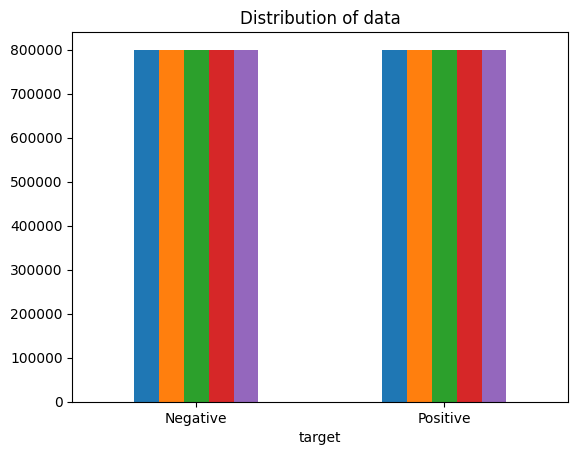

In [14]:
# Plotting the distribution for dataset.
ax = df.groupby('target').count().plot(kind='bar', title='Distribution of data',legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)
# Storing data in lists.
text, sentiment = list(df['text']), list(df['target'])

<Axes: xlabel='target', ylabel='count'>

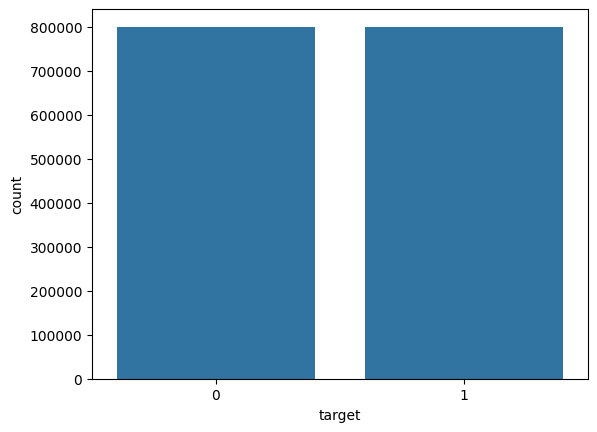

In [15]:
sns.countplot(x='target', data=df)

## Data Preprocessing

In [16]:
data=df[['text','target']]

In [17]:
data['target'].unique()

array([0, 1])

In [18]:
data_pos = data[data['target'] == 1]
data_neg = data[data['target'] == 0]

In [19]:
dataset = pd.concat([data_pos, data_neg])

In [20]:
dataset['text']=dataset['text'].str.lower()
dataset['text'].tail()

799995    sick  spending my day laying in bed listening ...
799996                                      gmail is down? 
799997                        rest in peace farrah! so sad 
799998    @eric_urbane sounds like a rival is flagging y...
799999    has to resit exams over summer...  wishes he w...
Name: text, dtype: object

In [21]:
STOPWORDS = set(stopwords.words('english'))
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
dataset['text'] = dataset['text'].apply(lambda text: cleaning_stopwords(text))
dataset['text'].tail()

799995    sick spending day laying bed listening @taylor...
799996                                          gmail down?
799997                               rest peace farrah! sad
799998    @eric_urbane sounds like rival flagging ads. m...
799999    resit exams summer... wishes worked harder fir...
Name: text, dtype: object

In [22]:
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)
dataset['text']= dataset['text'].apply(lambda x: cleaning_punctuations(x))
dataset['text'].tail()

799995    sick spending day laying bed listening taylors...
799996                                           gmail down
799997                                rest peace farrah sad
799998    ericurbane sounds like rival flagging ads much...
799999    resit exams summer wishes worked harder first ...
Name: text, dtype: object

In [23]:
def cleaning_repeating_char(text):
    return re.sub(r'(.)\1+', r'\1', text)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_repeating_char(x))
dataset['text'].tail()

799995    sick spending day laying bed listening taylors...
799996                                           gmail down
799997                                 rest peace farah sad
799998    ericurbane sounds like rival flaging ads much ...
799999    resit exams sumer wishes worked harder first y...
Name: text, dtype: object

In [24]:
def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_URLs(x))
dataset['text'].tail()

799995    sick spending day laying bed listening taylors...
799996                                           gmail down
799997                                 rest peace farah sad
799998    ericurbane sounds like rival flaging ads much ...
799999    resit exams sumer wishes worked harder first y...
Name: text, dtype: object

In [25]:
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_numbers(x))
dataset['text'].tail()

799995    sick spending day laying bed listening taylors...
799996                                           gmail down
799997                                 rest peace farah sad
799998    ericurbane sounds like rival flaging ads much ...
799999    resit exams sumer wishes worked harder first y...
Name: text, dtype: object

In [26]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
dataset['text'] = dataset['text'].apply(tokenizer.tokenize)
dataset['text'].head()

800000             [love, healthuandpets, u, guys, r, best]
800001    [im, meting, one, besties, tonight, cant, wait...
800002    [darealsunisakim, thanks, twiter, ad, sunisa, ...
800003    [sick, realy, cheap, hurts, much, eat, real, f...
800004                      [lovesbroklyn, efect, everyone]
Name: text, dtype: object

In [42]:
st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return text
dataset['text']= dataset['text'].apply(lambda x: stemming_on_text(x))
dataset['text'].head()

800000               [love, healthuandpet, u, guy, r, best]
800001    [im, mete, one, besti, tonight, cant, wait, gi...
800002    [darealsunisakim, thank, twiter, ad, sunisa, g...
800003    [sick, reali, cheap, hurt, much, eat, real, fo...
800004                       [lovesbroklyn, efect, everyon]
Name: text, dtype: object

In [43]:
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return text
dataset['text'] = dataset['text'].apply(lambda x: lemmatizer_on_text(x))
dataset['text'].head()

800000               [love, healthuandpet, u, guy, r, best]
800001    [im, mete, one, besti, tonight, cant, wait, gi...
800002    [darealsunisakim, thank, twiter, ad, sunisa, g...
800003    [sick, reali, cheap, hurt, much, eat, real, fo...
800004                       [lovesbroklyn, efect, everyon]
Name: text, dtype: object

In [44]:
X=data.text
y=data.target

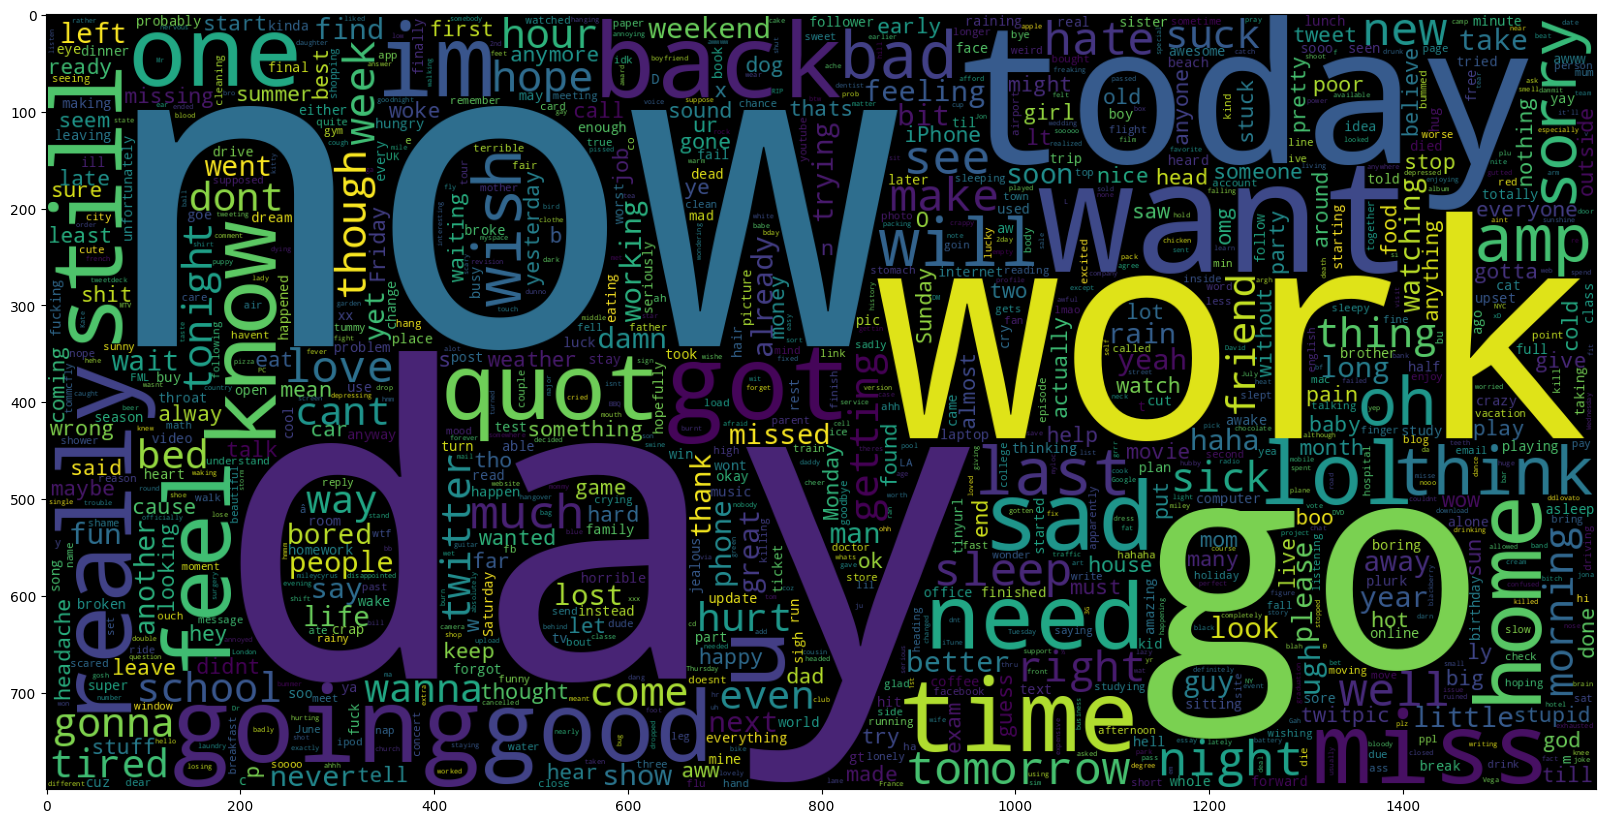

In [45]:
data_neg = data['text'][:800000]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

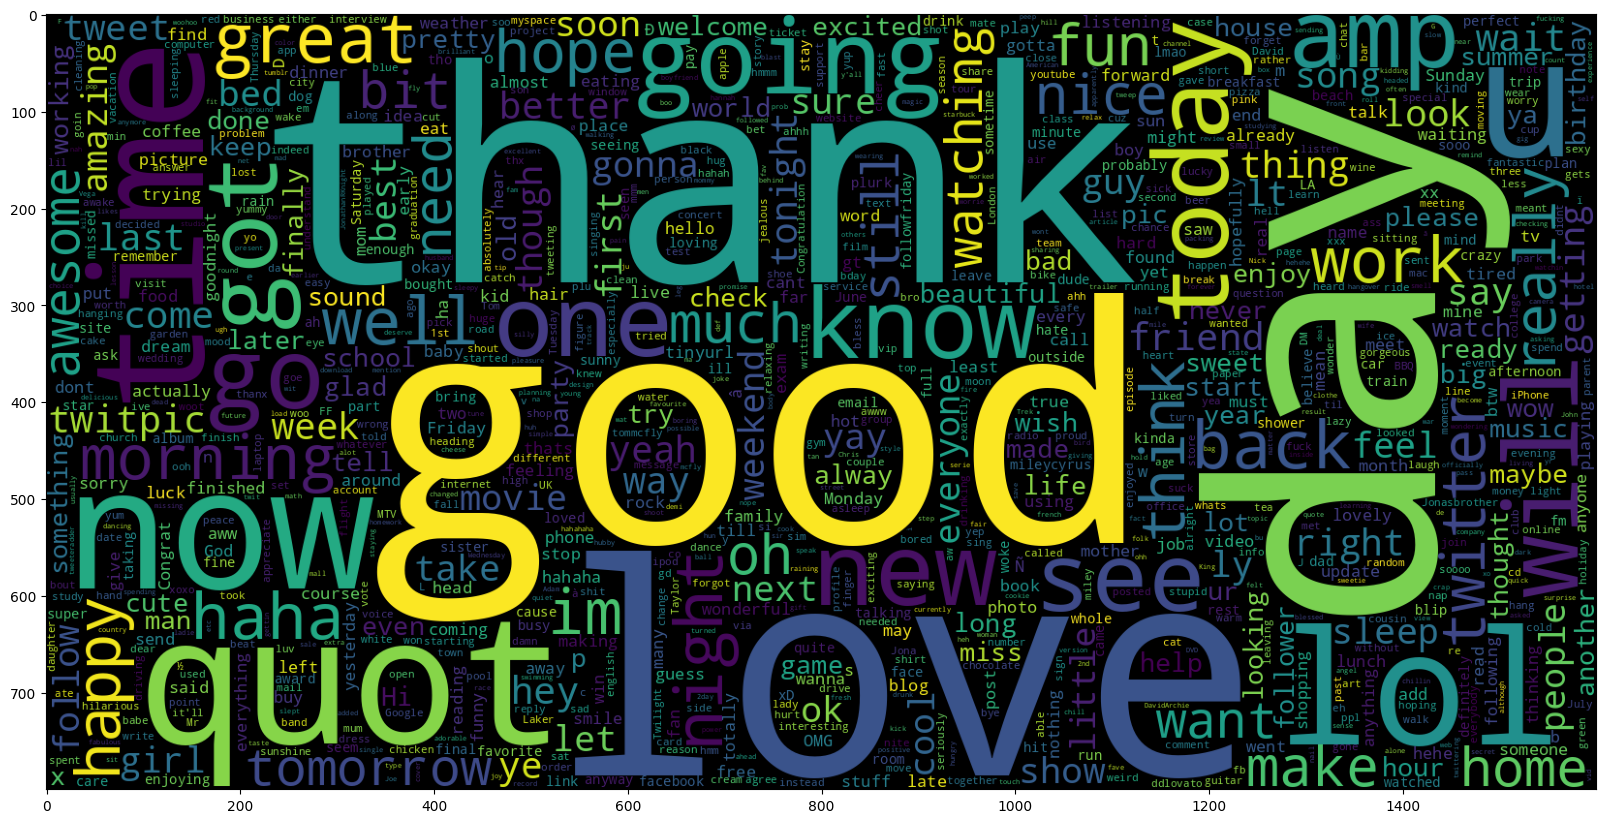

In [46]:
data_pos = data['text'][800000:]
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
              collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (20,20))
plt.imshow(wc)

## Splitting Dataset into Testing and Training Subsets

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2)

## Transforming Data using TF-IDF Vectorizer

In [48]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print('No. of feature_words: ', len(vectoriser.get_feature_names_out()))

No. of feature_words:  500000


In [49]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

## Function for Evaluating Model Performance

In [50]:
def model_Evaluate(model):
  # Predict values for Test dataset
  y_pred = model.predict(X_test)
  # Print the evaluation metrics for the dataset.
  print(classification_report(y_test, y_pred))
  # Compute and plot the Confusion matrix
  cf_matrix = confusion_matrix(y_test, y_pred)
  categories = ['Negative','Positive']
  group_names = ['True Neg','False Pos', 'False Neg','True Pos']
  group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
  labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
  xticklabels = categories, yticklabels = categories)
  plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
  plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
  plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

## Building Models

### Bernoulli Naive Bayes Classifier

              precision    recall  f1-score   support

           0       0.80      0.79      0.80    159557
           1       0.80      0.81      0.80    160443

    accuracy                           0.80    320000
   macro avg       0.80      0.80      0.80    320000
weighted avg       0.80      0.80      0.80    320000



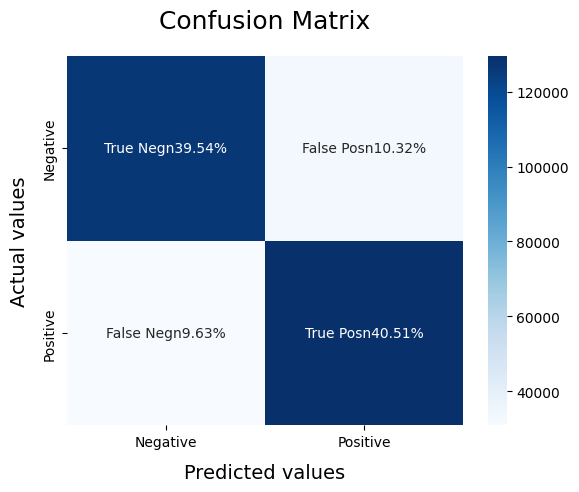

In [51]:
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)
y_pred1 = BNBmodel.predict(X_test)

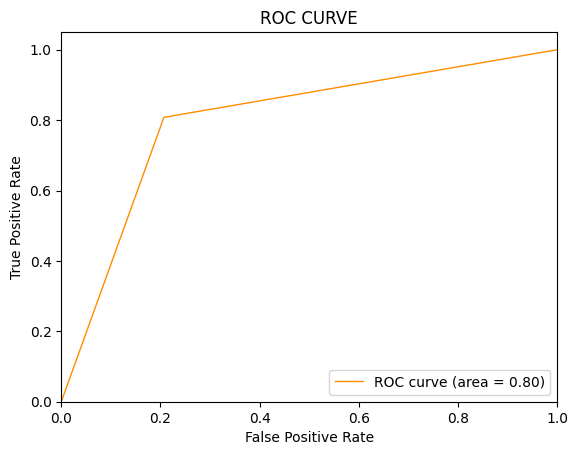

In [52]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

### Support Vector Machine (SVM) Model

              precision    recall  f1-score   support

           0       0.82      0.81      0.81    159557
           1       0.81      0.82      0.82    160443

    accuracy                           0.82    320000
   macro avg       0.82      0.82      0.82    320000
weighted avg       0.82      0.82      0.82    320000



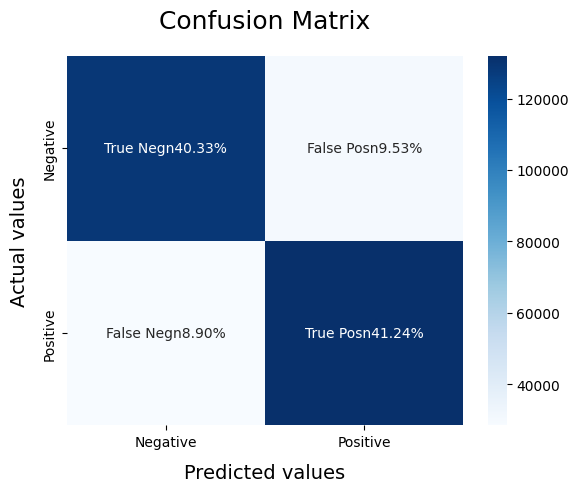

In [53]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)
y_pred2 = SVCmodel.predict(X_test)

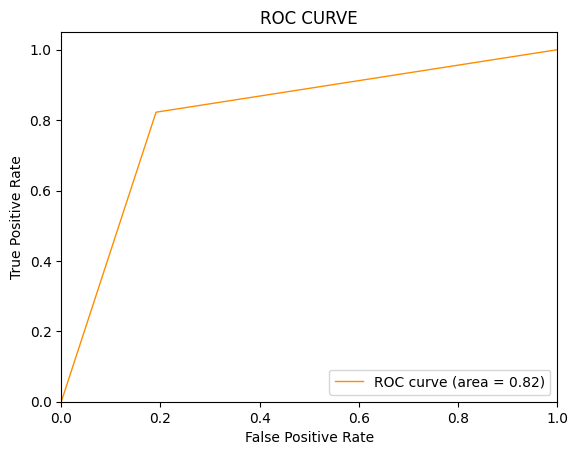

In [54]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred2)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

### Logistic Regression

              precision    recall  f1-score   support

           0       0.83      0.82      0.82    159557
           1       0.82      0.83      0.83    160443

    accuracy                           0.83    320000
   macro avg       0.83      0.83      0.83    320000
weighted avg       0.83      0.83      0.83    320000



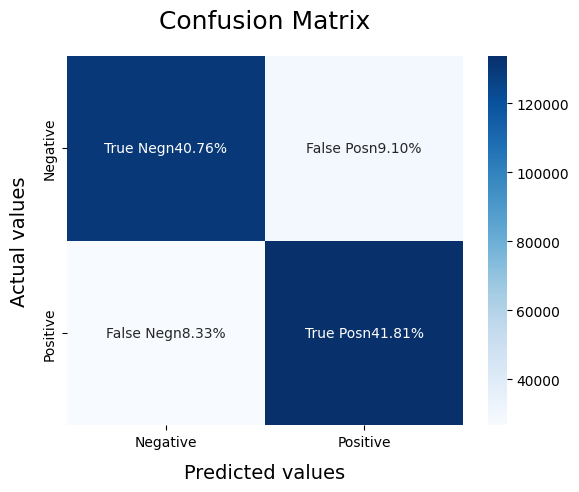

In [55]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)
y_pred3 = LRmodel.predict(X_test)

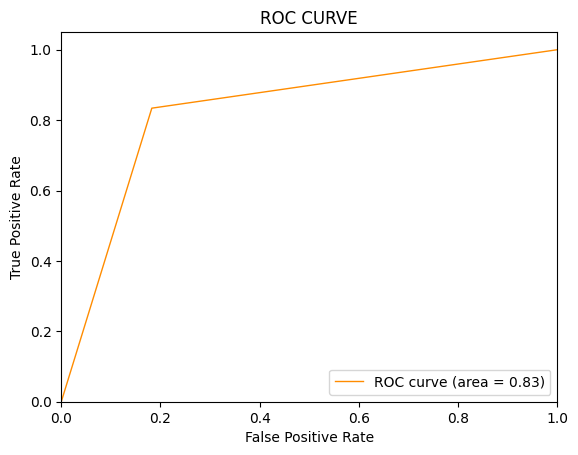

In [56]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred3)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()